# Add-on Bundling & Pricing — Modeling Notebook

This notebook imports a small `addon_bundling` package to:
1) generate synthetic data,
2) visualize distributions,
3) train **M1 (propensity)** & **M2 (price/elasticity)** with XGBoost,
4) inspect **feature importances** and a **sample tree**,
5) run the **optimizer** to get top-K offers (probability-ranked, price ≤ per-add-on list price).

> Tip: The next cell bootstraps the `addon_bundling/` modules in this environment so the notebook is self-contained.

In [ ]:
!pip install xgboost scikit-learn pandas matplotlib numpy graphviz

import os, pathlib
pkg_dir = pathlib.Path('addon_bundling')
pkg_dir.mkdir(exist_ok=True)
(pkg_dir / '__init__.py').write_text('# package bootstrap\n')

# config
(pkg_dir / 'config.py').write_text('''\
from dataclasses import dataclass
from typing import Dict

RNG_SEED = 42
PRICE_BUCKETS = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0]

ADDON_META: Dict[str, Dict[str, float]] = {
    "seat_upgrade": {"base_price": 30.0, "cost": 3.0},
    "baggage_bundle": {"base_price": 20.0, "cost": 1.5},
    "lounge_access": {"base_price": 25.0, "cost": 5.0},
    "wifi": {"base_price": 15.0, "cost": 0.6},
    "priority_boarding": {"base_price": 10.0, "cost": 0.2},
}

@dataclass
class Policy:
    min_margin_pct: float = 0.1
    max_discount_pct: float = 0.5
    fairness_block_cc_specific: bool = True
''')

# features
(pkg_dir / 'features.py').write_text('''\
from typing import List
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

CAT_BASE: List[str] = ["route_od", "payment_type", "loyalty_tier", "season"]
ITEM_COL: List[str] = ["addon_id"]
CATEGORICAL: List[str] = CAT_BASE + ITEM_COL

NUMERIC: List[str] = [
    "flight_duration_min",
    "dep_hour_local",
    "pax_count",
    "days_to_departure",
    "purchased_any_addon",
    "used_upgrade",
]

PRICE_NUMERIC: List[str] = NUMERIC + [
    "price_offered", "price_list", "discount_pct", "price_x_days", "price_x_pax"
]

TARGET = "label_purchase"
GROUP_KEY = "booking_id"

preprocessor_propensity = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL),
        ("num", StandardScaler(), NUMERIC),
    ]
)

preprocessor_price = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL),
        ("num", StandardScaler(), PRICE_NUMERIC),
    ]
)

def assert_unique_columns(df: pd.DataFrame, cols: List[str]) -> None:
    idx = pd.Index(cols)
    if not idx.is_unique:
        dupes = idx[idx.duplicated()].tolist()
        raise AssertionError(f"Duplicate column selections detected: {dupes}")
''')

# data_gen.py
(pkg_dir / 'data_gen.py').write_text('''\
from typing import Dict, List
import numpy as np
import pandas as pd
from .config import RNG_SEED, ADDON_META

RNG = np.random.default_rng(RNG_SEED)

ROUTES = ["ORD_SFO", "SFO_ORD", "LAX_JFK", "JFK_LAX", "IAH_DEN", "DEN_IAH", "EWR_MCO", "MCO_EWR"]
PAYMENT_TYPES = ["credit_card", "points", "mixed"]
TIERS = ["None", "Silver", "Gold", "Platinum"]
SEASONS = ["Q1", "Q2", "Q3", "Q4"]

AFFINITY = {
    "seat_upgrade": 0.28,
    "baggage_bundle": 0.18,
    "lounge_access": 0.12,
    "wifi": 0.22,
    "priority_boarding": 0.16,
}

ELASTICITY = {
    "seat_upgrade": 0.045,
    "baggage_bundle": 0.055,
    "lounge_access": 0.050,
    "wifi": 0.040,
    "priority_boarding": 0.065,
}

def _route_mix(route: str) -> float:
    if route in {"LAX_JFK", "JFK_LAX"}:
        return 0.25
    if route.startswith("EWR") or route.endswith("EWR"):
        return 0.15
    return 0.1

def generate_synthetic_training(n_bookings: int = 4000, price_jitter: float = 0.3) -> pd.DataFrame:
    rows: List[Dict] = []
    for i in range(n_bookings):
        b = f"B{100000+i}"
        route = RNG.choice(ROUTES)
        flight_duration_min = int(RNG.normal(210, 60))
        dep_hour_local = int(RNG.integers(5, 22))
        pax_count = int(RNG.integers(1, 5))
        days_to_departure = int(np.clip(RNG.normal(21, 14), 0, 120))
        payment_type = RNG.choice(PAYMENT_TYPES, p=[0.65, 0.25, 0.10])
        loyalty_tier = RNG.choice(TIERS, p=[0.5, 0.25, 0.18, 0.07])
        season = RNG.choice(SEASONS)
        purchased_any_addon = int(RNG.random() < 0.25)
        used_upgrade = int(RNG.random() < 0.12)

        for addon_id, meta in ADDON_META.items():
            list_price = meta["base_price"] * (1.0 + 0.2 * RNG.normal(0, 1))
            offered_price = max(1.0, list_price * (1.0 - price_jitter*RNG.random()))
            discount_pct = (list_price - offered_price) / max(list_price, 1e-6)

            base = -1.2
            base += AFFINITY[addon_id]
            base += 0.002 * (flight_duration_min - 180)
            base += 0.08 * (pax_count - 1)
            base += -0.02 * (days_to_departure - 14) / 7
            base += 0.25 if payment_type == "points" else 0.0
            base += 0.20 if loyalty_tier in {"Gold", "Platinum"} else 0.0
            base += 0.15 if purchased_any_addon else 0.0
            base += 0.12 if used_upgrade and addon_id == "lounge_access" else 0.0
            base += _route_mix(route)

            price_term = -ELASTICITY[addon_id] * offered_price
            price_term += 0.002 * offered_price * (days_to_departure < 7)
            price_term += -0.002 * offered_price * (payment_type == "points")

            logit = base + price_term
            prob = 1 / (1 + np.exp(-logit))
            label_purchase = int(RNG.random() < prob)

            rows.append({
                "booking_id": b,
                "addon_id": addon_id,
                "label_purchase": label_purchase,
                "price_offered": float(offered_price),
                "price_list": float(list_price),
                "discount_pct": float(discount_pct),
                "route_od": route,
                "flight_duration_min": float(flight_duration_min),
                "dep_hour_local": int(dep_hour_local),
                "pax_count": int(pax_count),
                "days_to_departure": int(days_to_departure),
                "payment_type": payment_type,
                "loyalty_tier": loyalty_tier,
                "season": season,
                "purchased_any_addon": int(purchased_any_addon),
                "used_upgrade": int(used_upgrade),
            })
    return pd.DataFrame(rows)
''')

# models
(pkg_dir / 'models.py').write_text('''\
import numpy as np
import pandas as pd
from typing import Optional
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from .features import (
    CAT_BASE, ITEM_COL, NUMERIC, CATEGORICAL, PRICE_NUMERIC,
    TARGET, GROUP_KEY,
    preprocessor_propensity, preprocessor_price,
    assert_unique_columns,
)

def train_propensity_model(df: pd.DataFrame) -> Pipeline:
    assert TARGET in df, "Missing target column"
    X_cols = CAT_BASE + ITEM_COL + NUMERIC
    assert_unique_columns(df, X_cols)
    X = df[X_cols].copy()
    y = df[TARGET].astype(int).values
    gkf = GroupKFold(n_splits=5)
    groups = df[GROUP_KEY]
    best_auc = -np.inf
    best_pipe: Optional[Pipeline] = None
    for fold, (tr, va) in enumerate(gkf.split(X, y, groups=groups)):
        pipe = Pipeline([
            ("prep", preprocessor_propensity),
            ("clf", XGBClassifier(
                n_estimators=400,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                eval_metric="logloss",
                n_jobs=-1,
            )),
        ])
        pipe.fit(X.iloc[tr], y[tr])
        proba = pipe.predict_proba(X.iloc[va])[:, 1]
        auc = roc_auc_score(y[va], proba)
        ap = average_precision_score(y[va], proba)
        print(f"[M1][Fold {fold}] AUC={auc:.4f} AP={ap:.4f}")
        if auc > best_auc:
            best_auc = auc
            best_pipe = pipe
    print(f"[M1] Selected model AUC={best_auc:.4f}")
    assert best_pipe is not None
    return best_pipe

def train_price_elasticity_model(df: pd.DataFrame) -> Pipeline:
    df_local = df.copy()
    df_local["price_x_days"] = df_local["price_offered"] * df_local["days_to_departure"].astype(float)
    df_local["price_x_pax"]  = df_local["price_offered"] * df_local["pax_count"].astype(float)
    X_cols = CATEGORICAL + PRICE_NUMERIC
    assert_unique_columns(df_local, X_cols)
    X = df_local[X_cols].copy()
    y = df_local[TARGET].astype(int).values
    gkf = GroupKFold(n_splits=5)
    groups = df_local[GROUP_KEY]
    best_auc = -np.inf
    best_pipe: Optional[Pipeline] = None
    for fold, (tr, va) in enumerate(gkf.split(X, y, groups=groups)):
        pipe = Pipeline([
            ("prep", preprocessor_price),
            ("clf", XGBClassifier(
                n_estimators=500,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                eval_metric="logloss",
                n_jobs=-1,
            )),
        ])
        pipe.fit(X.iloc[tr], y[tr])
        proba = pipe.predict_proba(X.iloc[va])[:, 1]
        auc = roc_auc_score(y[va], proba)
        ap = average_precision_score(y[va], proba)
        print(f"[M2][Fold {fold}] AUC={auc:.4f} AP={ap:.4f}")
        if auc > best_auc:
            best_auc = auc
            best_pipe = pipe
    print(f"[M2] Selected model AUC={best_auc:.4f}")
    assert best_pipe is not None
    return best_pipe
''')

# optimizer.py
(pkg_dir / 'optimizer.py').write_text('''\
from dataclasses import dataclass
from typing import Dict, List
import pandas as pd
from .features import CAT_BASE, ITEM_COL, NUMERIC, CATEGORICAL, PRICE_NUMERIC
from .config import Policy

@dataclass
class AddonOffer:
    addon_id: str
    price: float
    predicted_prob: float
    expected_profit: float

def feasible(policy: Policy, list_price: float, offer_price: float, cost: float = 0.0) -> bool:
    if offer_price > list_price:
        return False
    discount_pct = (list_price - offer_price) / max(list_price, 1e-6)
    if discount_pct > policy.max_discount_pct:
        return False
    margin_pct = (offer_price - cost) / max(offer_price, 1e-6)
    return margin_pct >= policy.min_margin_pct

def optimize_offers(
    context_rows: pd.DataFrame,
    propensity_model,
    price_model,
    price_grid: List[float],
    policy: Policy,
    addon_costs: Dict[str, float],
    addon_candidates: List[str],
    top_k: int = 2,
    list_price_map: Dict[str, float] | None = None,
) -> List[AddonOffer]:
    if not list_price_map:
        raise ValueError("list_price_map is required and cannot be empty")
    missing = [a for a in addon_candidates if a not in list_price_map]
    if missing:
        raise ValueError(f"list_price_map missing add-ons: {missing}")
    per_addon_best: Dict[str, AddonOffer] = {}
    for addon in addon_candidates:
        row = context_rows.copy()
        row["addon_id"] = addon
        list_price = float(list_price_map[addon])
        cost = addon_costs.get(addon, 0.0)
        best_offer = None
        for p in price_grid:
            if not feasible(policy, list_price=list_price, offer_price=p, cost=cost):
                continue
            X2 = row[(CAT_BASE + ITEM_COL)].copy()
            X2 = X2.assign(
                price_offered=p,
                price_list=list_price,
                discount_pct=(list_price - p) / max(list_price, 1e-6),
                price_x_days=p * float(row["days_to_departure"].iloc[0]),
                price_x_pax=p * float(row["pax_count"].iloc[0]),
                flight_duration_min=float(row["flight_duration_min"].iloc[0]),
                dep_hour_local=int(row["dep_hour_local"].iloc[0]),
                pax_count=int(row["pax_count"].iloc[0]),
                days_to_departure=int(row["days_to_departure"].iloc[0]),
                purchased_any_addon=int(row["purchased_any_addon"].iloc[0]),
                used_upgrade=int(row["used_upgrade"].iloc[0]),
            )
            X2 = X2[(CATEGORICAL + PRICE_NUMERIC)]
            prob = float(price_model.predict_proba(X2)[:, 1][0])
            offer = AddonOffer(addon_id=addon, price=p, predicted_prob=prob, expected_profit=prob * (p - cost))
            if (best_offer is None) or (offer.predicted_prob > best_offer.predicted_prob):
                best_offer = offer
        if best_offer is not None:
            per_addon_best[addon] = best_offer
    offers = sorted(per_addon_best.values(), key=lambda o: o.predicted_prob, reverse=True)
    return offers[:top_k]
''')

print('Bootstrapped addon_bundling/ package. You can now import it below.')

Bootstrapped addon_bundling/ package. You can now import it below.


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from addon_bundling.config import ADDON_META, PRICE_BUCKETS, Policy
from addon_bundling.data_gen import generate_synthetic_training
from addon_bundling.models import train_propensity_model, train_price_elasticity_model
from addon_bundling.features import TARGET
from addon_bundling.optimizer import optimize_offers
print('Imports OK')


Imports OK


In [ ]:
df = generate_synthetic_training(n_bookings=4000)
df.head()


,booking_id,addon_id,label_purchase,price_offered,price_list,discount_pct,route_od,flight_duration_min,dep_hour_local,pax_count,days_to_departure,payment_type,loyalty_tier,season,purchased_any_addon,used_upgrade
0,B100000,seat_upgrade,0,25.859340,29.899193,0.135116,ORD_SFO,147.0,18,2,34,credit_card,Platinum,Q4,0,0
1,B100000,baggage_bundle,0,18.647025,23.111168,0.193160,ORD_SFO,147.0,18,2,34,credit_card,Platinum,Q4,0,0
2,B100000,lounge_access,0,25.473902,27.337547,0.068172,ORD_SFO,147.0,18,2,34,credit_card,Platinum,Q4,0,0
3,B100000,wifi,0,9.113253,12.123352,0.248289,ORD_SFO,147.0,18,2,34,credit_card,Platinum,Q4,0,0
4,B100000,priority_boarding,0,8.606020,9.630275,0.106358,ORD_SFO,147.0,18,2,34,credit_card,Platinum,Q4,0,0


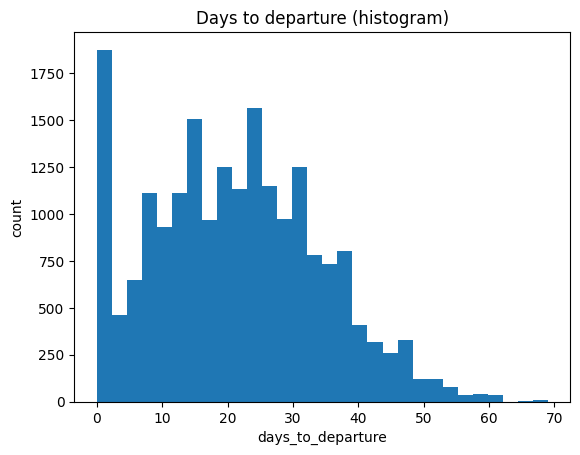

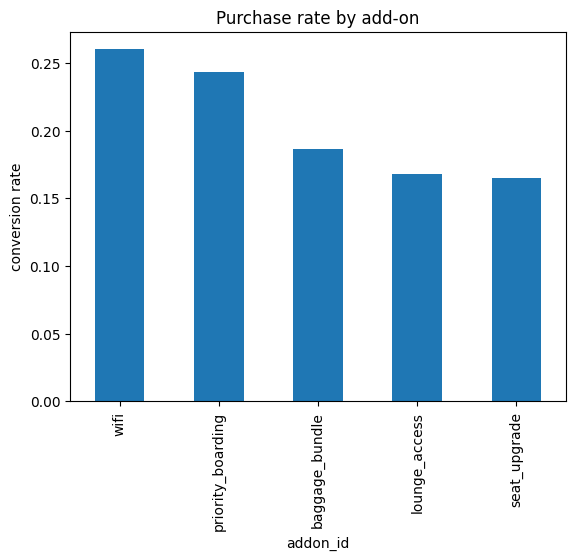

In [ ]:
# 1) Days to departure
plt.figure()
df['days_to_departure'].plot(kind='hist', bins=30)
plt.title('Days to departure (histogram)')
plt.xlabel('days_to_departure')
plt.ylabel('count')
plt.show()

addon_rate = df.groupby('addon_id')[TARGET].mean().sort_values(ascending=False)
plt.figure()
addon_rate.plot(kind='bar')
plt.title('Purchase rate by add-on')
plt.xlabel('addon_id')
plt.ylabel('conversion rate')
plt.show()



In [ ]:
propensity_model = train_propensity_model(df)
price_model = train_price_elasticity_model(df)
print('Models trained')


[M1][Fold 0] AUC=0.5625 AP=0.2553
[M1][Fold 1] AUC=0.5281 AP=0.2312
[M1][Fold 2] AUC=0.5285 AP=0.2226
[M1][Fold 3] AUC=0.5573 AP=0.2278
[M1][Fold 4] AUC=0.5657 AP=0.2391
[M1] Selected model AUC=0.5657
[M2][Fold 0] AUC=0.5695 AP=0.2556
[M2][Fold 1] AUC=0.5355 AP=0.2401
[M2][Fold 2] AUC=0.5540 AP=0.2342
[M2][Fold 3] AUC=0.5547 AP=0.2205
[M2][Fold 4] AUC=0.5654 AP=0.2425
[M2] Selected model AUC=0.5695
Models trained


In [ ]:
# Map feature importances to post-transformer feature names (M2)
preproc = price_model.named_steps['prep']
feature_names = preproc.get_feature_names_out()
clf = price_model.named_steps['clf']
importances = clf.feature_importances_

import pandas as pd
imp = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
    .sort_values('importance', ascending=False)
    .head(30)
)
imp


,feature,importance
13,cat__loyalty_tier_Platinum,0.033961
31,num__price_list,0.033451
23,cat__addon_id_wifi,0.033313
10,cat__payment_type_points,0.032668
3,cat__route_od_JFK_LAX,0.031718
30,num__price_offered,0.031104
19,cat__addon_id_baggage_bundle,0.030887
2,cat__route_od_IAH_DEN,0.030771
21,cat__addon_id_priority_boarding,0.029757
32,num__discount_pct,0.029519


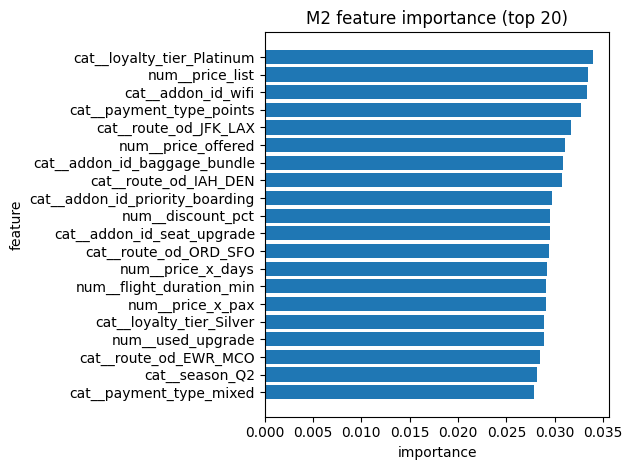

In [ ]:
top = imp.head(20).sort_values('importance', ascending=True)
plt.figure()
plt.barh(top['feature'], top['importance'])
plt.title('M2 feature importance (top 20)')
plt.xlabel('importance')
plt.ylabel('feature')
plt.tight_layout()
plt.show()


<Figure size 3000x3000 with 0 Axes>

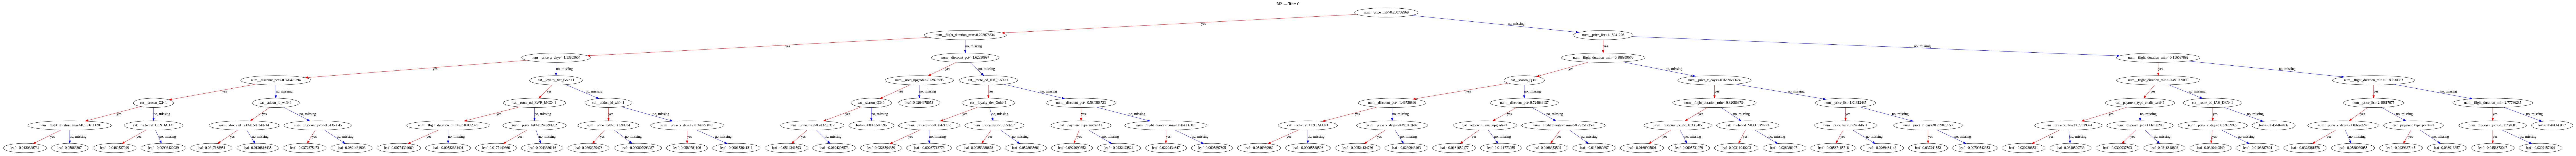

In [ ]:
from xgboost import plot_tree
booster = price_model.named_steps['clf'].get_booster()
feature_names = price_model.named_steps["prep"].get_feature_names_out().tolist()
booster.feature_names = feature_names
plt.figure(figsize=(30, 30))
plot_tree(booster, tree_idx=0)
plt.title('M2 — Tree 0')
plt.gcf().set_size_inches(150, 100)
plt.show()

In [ ]:
# Optimize offers (probability-ranked; one price per add-on; price ≤ list per add-on)
ctx = pd.DataFrame([{
    'booking_id': 'B_demo',
    'route_od': 'ORD_SFO',
    'flight_duration_min': 270,
    'dep_hour_local': 9,
    'pax_count': 2,
    'days_to_departure': 14,
    'payment_type': 'credit_card',
    'loyalty_tier': 'Gold',
    'season': 'Q4',
    'purchased_any_addon': 0,
    'used_upgrade': 0,
}])
addon_costs = {k: v['cost'] for k, v in ADDON_META.items()}
price_list_map = {k: float(v['base_price']) for k, v in ADDON_META.items()}
offers = optimize_offers(
    context_rows=ctx,
    propensity_model=propensity_model,
    price_model=price_model,
    price_grid=PRICE_BUCKETS,
    policy=Policy(min_margin_pct=0.1, max_discount_pct=0.5),
    addon_costs=addon_costs,
    addon_candidates=list(ADDON_META.keys()),
    top_k=2,
    list_price_map=price_list_map,
)
offers


[AddonOffer(addon_id='wifi', price=10.0, predicted_prob=0.31802067160606384, expected_profit=2.989394313097),
 AddonOffer(addon_id='baggage_bundle', price=10.0, predicted_prob=0.22780486941337585, expected_profit=1.9363413900136948)]

Notes to self
- payment method should be type of card
- why is booking_id in the optimization step?
- and what if we wanted pricing buckets for each item... or maybe make pricing buckets based on discount rate not price.